# Instagram Like Prediction @310ai Competition - Data Understanding, Collection & Preparation

This notebook is for the competition posted by the @310ai on 15th of April. I will approach the competition as a project following the CRISP-DM methodology and try to explain the approach in every steps of the way.

The main and short summary of this competition is **"given an Instagram post predict the number of likes"**.

## Business Understanding
First thing first, there are some important points that we have to consider which are forced by the Instagram. This points will result in some features that are effective in percision of the model. In the following section we will discuss them further.

***Are we try to predict the number of likes for an Instagram post of our own or not?***

This question might seem a little odd, but let me explain it. Each Instagram post consists of some metrics that show the performance of the post among the users. We will call these **"Performance Metrics"**. Some of these performance metrics such as amount of like, amount of columns, caption and etc, are publicly availble, in other words, any user on the Instagram can see them.

But some of the performance metrics, are not publicly available, in order to see them, we need to authenticate as the owner of the page (will discuss about this part further in this section.), some of these private performance metrics are, amount of share, amount of save, amount of reach, amount of profile visits, amount of follows, amount of impression and etc.

Obviously, if we try to predict the amount of like for a page that we don't own, we can not access these features, we will go for a page that we don't have access to it for this competition.

Another to have in mind is that, since the post we are going to predict the amount of like for it, is not actually existing, the amount of performance metrics can't be predicted preciesly. In other words, how we can estimate the amount of comments a hypothetical post might recieve if we don't post it actually. Due to this abstraction, the performance metrics for each post is not a good feature for this deed.

In the further section I will try to address the questions of the competitions in combination of code and text. Please have in mind to follow the chosen methodology I might change the order of questions.

## Data Requirements and Data Collection

In this section I will tackle the questions mainly related to these parts of the challenge. As we discussed above some useful features introduced that might have effect on the precision of the prediction. But there are some other features, further I will point to some features that are related to the page of the published post.

### What Features you used?

Each and every page on the Instagram has some features that will distinguish it from other pages, some of these features are like the features discussed above, performance metrics, and some of them are identifiers. Some of the identifiers features are:
- `id`: a unique id that is allocated by the Instagram.
- `username`: a unique username that each user when created the page chose.

Also there are some other features that we will investigate, these features are:
- `category_name`: each page based on the published content and some other traits, are categorized into different categories, for instance, Blogger, Personal Blog, Design & Fashion, chef and etc.
- `follower`: amount of followers the page has.
- `following`: amount of pages that the target page is following.
- `ar_effect`: whether the page has published ar effects in the Instagram or not.
- `type_business`: whether the page identified itself as business account or not.
- `type_professional`: whether the page identified itself as professional account or not.
- `verified`: whether the page is verified or not.
- `reel_count`: amount of igtvs posted by the page.
- `media_count`: amount of posts, posted by the page.

There are some features that are collected organically but can be calculated in the process of feature engineering. Some of them are:
- `reel_view`: The average view of igtvs posted by the page.
- `reel_comment`: The average of comments igtvs acquired.
- `reel_like`: The average of likes igtvs got.
- `reel_duration`: The average of igtv's duration posted by the page.
- `reel_frequency`: How often the page have posted the reels.
- `media_avg_view`: The average view of media posted by the page.
- `media_avg_comment`: The average of comments media acquired.
- `media_avg_like`: The average of likes media got.
- `media_avg_duration`: The average of media's duration posted by the page.
- `media_frequency`: How often the page have posted the media.

Last but not least, is the content of the image itself. There are multiple ways to have the content of the image as feature. For instance we can have a classifier network to detect what objects are present in the image and pass them to the like predictor model.

As you are aware, choosing the best strategy requires some tests, such as A/B tests and trial and error ones, for now I will chose the strategy which will be discussed further that is fastest and heuristic.

I will use a heuristic approach regarding the image content, I will use a pre-trained image classifier, `[NAME OF ARCHECTURE USED]`, but remove the last layer and pass an image vector created by network as a feature to a classifier.

### How do we collect the data?

As we discussed above, there are different kind of features, and each group can be collected via different methods.

The Instagram provides an API for developers, but due some restrictions and limitations, this API can not provide us the data that we seek. Based on this facts, we will use a heuristic way to collect the data. There will be 2 approaches regarding the matter. one approach which is not very tech-friendly (:D) is to create a scrapper with Selenium page in python to scrap the information we need. Selenium is a website testing library in python that can also be utilized into a webscrapper. This approach has another limitation excluse for users like me, since I'm in Iran right now, access to the Instagram is restricted and we have to use VPNs and geo-restriction bypasses, these tools add another layer of challenge and additional bottleneck. Another approach that I try to utilize, is to use the graphql endpoints to recieve the information needed in JSON format. Eventhough still use of VPNs and similar tools is needed in this approach, but unlike the Selenium this approach doesn't require to load the GUI of Instagram, its much more faster and eligble in a pipeline.

- end point for user information:
`https://www.instagram.com/{username}/?__a=1&__d=dis
`

- end point for post information:
`https://www.instagram.com/p/{post_ID}/?__a=1&__d=dis
`

getting training data for the model:
- each json response of an account gives 12 latest post
information:

  - Alt text information is here: `data['graphql']['user']['edge_owner_to_timeline_media']['edges'][0]['node']['accessibility_caption']`
    - each node has type, `GraphImage` is posts which have alt text.
    - `GraphVideo` doesn't have alt text.
    - `GraphSideCar` is carousel and have alt text.
  - number of comments is here: `data['graphql']['user']['edge_owner_to_timeline_media']['edges'][0]['node']['edge_media_to_comment']['count']`
  - number of likes is here: `data['graphql']['user']['edge_owner_to_timeline_media']['edges'][0]['node']['edge_liked_by']['count']`


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
from datetime import datetime
import json
import re
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from tqdm import tqdm
import time
from os import path, listdir
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import cv2
from rich.console import Console
from rich.theme import Theme
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

ramin_theme = Theme({
    'success': 'italic bright_green',
    'error': 'bold red',
    'progress': 'italic yellow',
    'header': 'bold cyan',
})
console = Console(theme=ramin_theme)


# reading credentials for loging into the instagram account
with open('credentials.json') as f:
    creds = json.load(f)
    login_username = creds['username']
    login_password = creds['password']

# reading accounts lists for gathering training data.
with open('Data/top_100_follower.txt') as f:
    lines = f.readlines()
top_100_followers = lines[0].split(',')

with open('Data/top_100_posts.txt') as f:
    lines = f.readlines()
top_100_posts = lines[0].split(',')

# Loading the pretrained model for object classification
efficient_net = models.efficientnet_b7(pretrained=True)
efficient_net.eval()

# Preparing a standard transformation and categories of ImageNet
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406],
                         std=[.229, .224, .225])
])
image_directory = 'Data/Images'

# reading ImageNet Classes
with open('Data/ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
    categories = [s.strip() for s in f.readlines()]

def flatten(lst):
    """A helper function to flatten any dimensional python list to 1D one.

    Args:
        lst (list): multi dimension python list

    Returns:
        list: flattened list
    """
    rt = []
    for i in lst:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

c:\Users\Mr-Khosravian\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mr-Khosravian\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Logging into the Instagram account
This step is necesary for getting information of the images, since majority of information in Instagram are locked behind the authentication wall.

In [5]:
link = 'https://www.instagram.com/accounts/login/'
login_url = 'https://www.instagram.com/accounts/login/ajax/'
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36',
            'referer':'https://www.instagram.com/',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate, br',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
            'Sec-Fetch-Dest': 'document',
            'Sec-Fetch-Mode': 'navigate',
            'Sec-Fetch-Site': 'none',
            'Sec-Fetch-User': '?1',
            'TE': 'trailers'
}


current_time = int(datetime.now().timestamp())
response = requests.Session().get(link, headers=headers)
if response.ok:
    csrf = re.findall(r'csrf_token\\":\\"(.*?)\\"',response.text)[0]
    username = login_username
    password = login_password

    payload = {
        'username': username,
        'enc_password': f'#PWD_INSTAGRAM_BROWSER:0:{current_time}:{password}',
        'queryParams': {},
        'optIntoOneTap': 'false',
        'stopDeletionNonce': '',
        'trustedDeviceRecords': '{}'
    }

    login_header = {
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36',
        "X-Requested-With": "XMLHttpRequest",
        "Referer": "https://www.instagram.com/accounts/login/",
        "X-CSRFToken": csrf,
        'Accept': '*/*',
        'Accept-Language': 'en-US,en;q=0.5',
        'X-Instagram-AJAX': 'c6412f1b1b7b',
        'X-IG-App-ID': '936619743392459',
        'X-ASBD-ID': '198387',
        'X-IG-WWW-Claim': '0',
        'X-Requested-With': 'XMLHttpRequest',
        'Origin': 'https://www.instagram.com',
        'DNT': '1',
        'Connection': 'keep-alive',
        'Referer': 'https://www.instagram.com/accounts/login/?',
        'Sec-Fetch-Dest': 'empty',
        'Sec-Fetch-Mode': 'cors',
        'Sec-Fetch-Site': 'same-origin',
    }

    login_response = requests.post(login_url, data=payload, headers=login_header)
    json_data = json.loads(login_response.text)


    if json_data['status'] == 'fail':
        print(json_data['message'])

    elif json_data["authenticated"]:
        print("login successful")
        cookies = login_response.cookies
        cookie_jar = cookies.get_dict()
        csrf_token = cookie_jar['csrftoken']
        print("csrf_token: ", csrf_token)
        session_id = cookie_jar['sessionid']
        print("session_id: ", session_id)

    else:
        print("login failed ", login_response.text)
else:
    print('error')
    print(response)

login successful
csrf_token:  xtO1nUnpXW8kOk59ZGwJbCYlqj0lFLdI
session_id:  1691538713%3AntJqvIU6HYiQWL%3A11%3AAYfZmtxK1i7GwGcymkPHghNaRj3f2F5gsF1PuLB9Cw


#### Collecting Data

The below cell is the main cell for collecting the data from the Instagram, since this code block is the longest block in the workspace, it's worth to discuss the parts of its structure. Please have in mind the best design pattern for this kind of task, is to create pipeline, but since this is a competition and understanding a pipeline might be difficult for reviewrs, I stick with this approach regarding the matter.

First thing, I have to check whether the data is present or not, if the **accounts** and **posts** dataset are present I'm reading them, otherwise I'm creating empty dataframes for each one of them with their corresponding features. I have to read the names of the accounts I want to get their information, for the training of this model, I have selected the top 100 pages with the most followers and top 100 pages with the most published posts. I call these **accounts dataset**.

For each username in the accounts dataset, I do these procedures:
1. I check whether I had acquired that account information or no, if I had, skip that account and go to the next account.
2. Then I send a request containing appropriate headers and previously acquired cookies from logining into the Instagram, to recieve account information. I sanity check the response to validate whether we have got the correct response or it's faulty (i.e. empty response, page got private, etc.).
3. Previously Discussed features then are extracted from the response json and saved into their coresponding variables or lists, some of these features have to be calculated, for instance, media & reel frequency, view, like, comment, duration average and etc. These features are calculated and saved into their correspoding variables.
4. I create a temporary dataframe for each account and add it to the main accounts dataframe.
5. Almost the same procedure is done for the posts information.
6. In the end, we will have 5 seconds delay between each username process, to honoring the rate limit of the Instagram.

In [13]:
try:
    main_df = pd.read_csv('Data/main v3.0.csv')
    main_df.drop(columns=['Unnamed: 0'], inplace=True)
except:
    main_df = pd.DataFrame(columns=['id', 'username', 'shortcode', 'post_type', 'like', 'comment', 'object', 'category_name', 'follower', 'following', 'ar_effect', 'type_business', 'type_professional', 'verified', 'reel_count', 'reel_avg_view', 'reel_avg_comment', 'reel_avg_like', 'reel_avg_duration', 'reel_frequency', 'media_count', 'media_avg_comment', 'media_avg_like', 'media_frequency'])


for username in tqdm(top_100_followers + top_100_posts):
    console.print(f'Getting Account Information: [cyan]{username}[/]',)
    if main_df['username'].str.contains(f'{username}').any():
        console.print('\tUser information already exist, skipping...', style='error')
        continue

    # loading account information
    session = {
            "csrf_token": csrf_token,
            "session_id": session_id
        }

    headers = {
            "x-csrftoken": session['csrf_token'],
            'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36',
            "X-Requested-With": "XMLHttpRequest",
            "Referer": "https://www.instagram.com/accounts/login/",
            'Accept': '*/*',
            'Accept-Language': 'en-US,en;q=0.5',
            'X-Instagram-AJAX': 'c6412f1b1b7b',
            'X-IG-App-ID': '936619743392459',
            'X-ASBD-ID': '198387',
            'X-IG-WWW-Claim': '0',
            'X-Requested-With': 'XMLHttpRequest',
            'Origin': 'https://www.instagram.com',
            'DNT': '1',
            'Connection': 'keep-alive',
            'Referer': 'https://www.instagram.com/accounts/login/?',
            'Sec-Fetch-Dest': 'empty',
            'Sec-Fetch-Mode': 'cors',
            'Sec-Fetch-Site': 'same-origin',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate, br',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1',
            'Sec-Fetch-Dest': 'document',
            'Sec-Fetch-Mode': 'navigate',
            'Sec-Fetch-Site': 'none',
            'Sec-Fetch-User': '?1',
            'TE': 'trailers'
        }

    cookies = {
            "sessionid": session['session_id'],
            "csrftoken": session['csrf_token']
        }
    url = f'https://www.instagram.com/{username}/?__a=1&__d=dis'
    res = requests.get(url, headers=headers, cookies=cookies)
    # add error handling here based on response codes, reference -> InstagramBot.py

    try:
        data = res.json()
    except:
        console.print('Something went wrong. Skipping...', style='error')
    if not data:
        console.print(f'\tResponse is empty for {username} skipping...', style='error')
        continue
    followers = data['graphql']['user']['edge_followed_by']['count']
    following = data['graphql']['user']['edge_follow']['count']
    ar_effect = data['graphql']['user']['has_ar_effects']
    id = data['graphql']['user']['id']
    type_business = data['graphql']['user']['is_business_account']
    type_professional = data['graphql']['user']['is_professional_account']
    category = data['graphql']['user']['category_name']
    verified = data['graphql']['user']['is_verified']
    reel_count = data['graphql']['user']['edge_felix_video_timeline']['count']
    media_count = data['graphql']['user']['edge_owner_to_timeline_media']['count']
    username = data['graphql']['user']['username']
    media = data['graphql']['user']['edge_owner_to_timeline_media']['edges']

    reel_view_list = []
    reel_like_list = []
    reel_comment_list = []
    reel_duration_list = []
    reel_timestamp_list = []

    media_like_list = []
    media_comment_list = []
    media_timestamp_list = []

    for video in data['graphql']['user']['edge_felix_video_timeline']['edges']:
        reel_view_list.append(video['node']['video_view_count'])
        reel_comment_list.append(video['node']['edge_media_to_comment']['count'])
        reel_timestamp_list.append(video['node']['taken_at_timestamp'])
        reel_like_list.append(video['node']['edge_liked_by']['count'])
        reel_duration_list.append(video['node']['video_duration'])
    
    # sometimes instagram result for video duration is None, this is sanity check
    reel_duration_list = [0 if duration is None else duration for duration in reel_duration_list]

    for medium in media:
        media_like_list.append(medium['node']['edge_liked_by']['count'])
        media_comment_list.append(medium['node']['edge_media_to_comment']['count'])
        media_timestamp_list.append(medium['node']['taken_at_timestamp'])
    
    reel_utc_list = [datetime.utcfromtimestamp(ts) for ts in reel_timestamp_list]
    media_utc_list = [datetime.utcfromtimestamp(ts) for ts in media_timestamp_list]

    reel_utc_difference_list = [reel_utc_list[i] - reel_utc_list[i+1] for i in range(len(reel_utc_list) - 1)]
    media_utc_difference_list = [media_utc_list[i] - media_utc_list[i+1] for i in range(len(media_utc_list) - 1)]

    if reel_count > 1:
        reel_frequency = np.mean(reel_utc_difference_list).days + (np.mean(reel_utc_difference_list).seconds / 86_400) + (np.mean(reel_utc_difference_list).microseconds / 1_000_000 / 84_600)
    else:
        reel_frequency = 0
    media_frequency = np.mean(media_utc_difference_list).days + (np.mean(media_utc_difference_list).seconds / 86_400) + (np.mean(media_utc_difference_list).microseconds / 1_000_000 / 84_600)

    reel_view_mean = np.mean(reel_view_list)
    reel_like_mean = np.mean(reel_like_list)
    reel_comment_mean = np.mean(reel_comment_list)
    reel_duration_mean = np.mean(reel_duration_list)

    media_like_mean = np.mean(media_like_list)
    media_comment_mean = np.mean(media_comment_list)

    for medium in media:
        shortcode = medium['node']['shortcode']
        media_type = medium['node']['__typename']
        media_display_url = medium['node']['display_url']
        media_like = medium['node']['edge_liked_by']['count']
        media_comment = medium['node']['edge_media_to_comment']['count']
        
        entry_lst = [id, username, shortcode, media_type, media_like, media_comment, None, category, followers, following, ar_effect, type_business, type_professional, verified, reel_count, reel_view_mean, reel_comment_mean, reel_like_mean, reel_duration_mean, reel_frequency, media_count, media_comment_mean, media_like_mean, media_frequency]
        main_df.loc[len(main_df)] = entry_lst
        main_df = main_df.astype({
            'ar_effect': bool,
            'type_business': bool,
            'type_professional': bool,
            'verified': bool,
        })
        if media_type == 'GraphImage' or media_type == 'GraphSidecar':
            if path.isfile(f'Data/Images/{shortcode}.jpg'):
                console.print('\tImage already exists, Skipping...', style='error')
                continue
            console.print(f'\tDownloading: {shortcode}', style='progress')
            res = requests.get(media_display_url)
            with open(f'Data/Images/{shortcode}.jpg', 'wb') as f:
                f.write(res.content)
            console.print('\tSaved!', style='success')
        main_df.to_csv('Data/main v3.0.csv')

  0%|          | 0/200 [00:00<?, ?it/s]

Getting Account Information: instagram

        User information already exist, skipping...

Getting Account Information: cristiano

        User information already exist, skipping...

Getting Account Information: leomessi

        User information already exist, skipping...

Getting Account Information: selenagomez

        User information already exist, skipping...

Getting Account Information: kyliejenner

        User information already exist, skipping...

Getting Account Information: therock

        User information already exist, skipping...

Getting Account Information: arianagrande

        User information already exist, skipping...

Getting Account Information: kimkardashian

        User information already exist, skipping...

Getting Account Information: beyonce

        User information already exist, skipping...

Getting Account Information: khloekardashian

        User information already exist, skipping...

Getting Account Information: justinbieber

        User information already exist, skipping...

Getting Account Information: nike

        User information already exist, skipping...

Getting Account Information: kendalljenner

        User information already exist, skipping...

  6%|▋         | 13/200 [00:00<00:01, 120.83it/s]

Getting Account Information: natgeo

        User information already exist, skipping...

Getting Account Information: taylorswift

        User information already exist, skipping...

Getting Account Information: virat.kohli

        User information already exist, skipping...

Getting Account Information: jlo

        User information already exist, skipping...

Getting Account Information: kourtneykardash

        User information already exist, skipping...

Getting Account Information: nickiminaj

        User information already exist, skipping...

Getting Account Information: neymarjr

        User information already exist, skipping...

Getting Account Information: mileycyrus

        User information already exist, skipping...

Getting Account Information: katyperry

        User information already exist, skipping...

Getting Account Information: zendaya

        User information already exist, skipping...

Getting Account Information: kevinhart4real

        User information already exist, skipping...

Getting Account Information: ddlovato

        User information already exist, skipping...

Getting Account Information: kingjames

        User information already exist, skipping...

 13%|█▎        | 26/200 [00:00<00:01, 116.13it/s]

Getting Account Information: badgalriri

        User information already exist, skipping...

Getting Account Information: realmadrid

        User information already exist, skipping...

Getting Account Information: champagnepapi

        User information already exist, skipping...

Getting Account Information: chrisbrownofficial

        User information already exist, skipping...

Getting Account Information: fcbarcelona

        User information already exist, skipping...

Getting Account Information: billieeilish

        User information already exist, skipping...

Getting Account Information: championsleague

        User information already exist, skipping...

Getting Account Information: k.mbappe

        User information already exist, skipping...

Getting Account Information: gal_gadot

        User information already exist, skipping...

Getting Account Information: vindiesel

        User information already exist, skipping...

Getting Account Information: lalalalisa_m

        User information already exist, skipping...

Getting Account Information: nasa

        User information already exist, skipping...

 19%|█▉        | 38/200 [00:00<00:01, 117.58it/s]

Getting Account Information: dualipa

        User information already exist, skipping...

Getting Account Information: priyankachopra

        User information already exist, skipping...

Getting Account Information: shakira

        User information already exist, skipping...

Getting Account Information: snoopdogg

        User information already exist, skipping...

Getting Account Information: shraddhakapoor

        User information already exist, skipping...

Getting Account Information: khaby00

        User information already exist, skipping...

Getting Account Information: nba

        User information already exist, skipping...

Getting Account Information: davidbeckham

        User information already exist, skipping...

Getting Account Information: gigihadid

        User information already exist, skipping...

Getting Account Information: jennierubyjane

        User information already exist, skipping...

Getting Account Information: aliaabhatt

        User information already exist, skipping...

Getting Account Information: victoriassecret

        User information already exist, skipping...

 25%|██▌       | 50/200 [00:00<00:01, 105.52it/s]

Getting Account Information: narendramodi

        User information already exist, skipping...

Getting Account Information: nehakakkar

        User information already exist, skipping...

Getting Account Information: bts.bighitofficial

        User information already exist, skipping...

Getting Account Information: ronaldinho

        User information already exist, skipping...

Getting Account Information: deepikapadukone

        User information already exist, skipping...

Getting Account Information: shawnmendes

        User information already exist, skipping...

Getting Account Information: katrinakaif

        User information already exist, skipping...

Getting Account Information: sooyaaa__

        User information already exist, skipping...

Getting Account Information: psg

        User information already exist, skipping...

Getting Account Information: emmawatson

        User information already exist, skipping...

Getting Account Information: roses_are_rosie

        User information already exist, skipping...

 30%|███       | 61/200 [00:00<00:01, 97.17it/s] 

Getting Account Information: justintimberlake

        User information already exist, skipping...

Getting Account Information: karimbenzema

        User information already exist, skipping...

Getting Account Information: raffinagita1717

        User information already exist, skipping...

Getting Account Information: marvel

        User information already exist, skipping...

Getting Account Information: tomholland2013

        User information already exist, skipping...

Getting Account Information: camila_cabello

        User information already exist, skipping...

Getting Account Information: jacquelinef143

        User information already exist, skipping...

Getting Account Information: premierleague

        User information already exist, skipping...

Getting Account Information: akshaykumar

        User information already exist, skipping...

Getting Account Information: anitta

        User information already exist, skipping...

Getting Account Information: urvashirautela

        User information already exist, skipping...

Getting Account Information: anushkasharma

        User information already exist, skipping...

 36%|███▋      | 73/200 [00:00<00:01, 102.35it/s]

Getting Account Information: willsmith

        User information already exist, skipping...

Getting Account Information: maluma

        User information already exist, skipping...

Getting Account Information: milliebobbybrown

        User information already exist, skipping...

Getting Account Information: marcelotwelve

        User information already exist, skipping...

Getting Account Information: 433

        User information already exist, skipping...

Getting Account Information: manchesterunited

        User information already exist, skipping...

Getting Account Information: karolg

        User information already exist, skipping...

Getting Account Information: zacefron

        User information already exist, skipping...

Getting Account Information: beingsalmankhan

        User information already exist, skipping...

Getting Account Information: iamzlatanibrahimovic

        User information already exist, skipping...

Getting Account Information: 9gag

        User information already exist, skipping...

Getting Account Information: whinderssonnunes

        User information already exist, skipping...

Getting Account Information: thv

        User information already exist, skipping...

 43%|████▎     | 86/200 [00:00<00:01, 107.33it/s]

Getting Account Information: bellahadid

        User information already exist, skipping...

Getting Account Information: paulpogba

        User information already exist, skipping...

Getting Account Information: juventus

        User information already exist, skipping...

Getting Account Information: leonardodicaprio

        User information already exist, skipping...

Getting Account Information: dishapatani

        User information already exist, skipping...

Getting Account Information: sergioramos

        User information already exist, skipping...

Getting Account Information: zara

        User information already exist, skipping...

Getting Account Information: chrishemsworth

        User information already exist, skipping...

Getting Account Information: tatawerneck

        User information already exist, skipping...

Getting Account Information: robertdowneyjr

        User information already exist, skipping...

Getting Account Information: paulodybala

        User information already exist, skipping...

 48%|████▊     | 97/200 [00:00<00:00, 103.89it/s]

Getting Account Information: chanelofficial

        User information already exist, skipping...

Getting Account Information: ladygaga

        User information already exist, skipping...

Getting Account Information: sunnyleone

        User information already exist, skipping...

Getting Account Information: theshaderoom

        User information already exist, skipping...

Getting Account Information: hollywoodunlocked

        User information already exist, skipping...

Getting Account Information: rvcjinsta

        User information already exist, skipping...

Getting Account Information: manotoofficial

        User information already exist, skipping...

Getting Account Information: tvnnoticias

        User information already exist, skipping...

Getting Account Information: instablog9ja

        User information already exist, skipping...

Getting Account Information: worldstar

        User information already exist, skipping...

Getting Account Information: uae_barq

        User information already exist, skipping...

 54%|█████▍    | 108/200 [00:01<00:00, 104.23it/s]

Getting Account Information: telemetro

        User information already exist, skipping...

Getting Account Information: bellanaijaonline

        User information already exist, skipping...

Getting Account Information: fashionnova

        User information already exist, skipping...

Getting Account Information: 3meed_news

        User information already exist, skipping...

Getting Account Information: melodia_musik

        User information already exist, skipping...

Getting Account Information: aboutcirebonid

        User information already exist, skipping...

Getting Account Information: infodenpasar

        User information already exist, skipping...

Getting Account Information: radiofarda

        User information already exist, skipping...

Getting Account Information: instantbollywood

        User information already exist, skipping...

Getting Account Information: iranintltv

        User information already exist, skipping...

Getting Account Information: fashionbombdaily

        User information already exist, skipping...

Getting Account Information: eldiario

        User information already exist, skipping...

Getting Account Information: arab2turk

        User information already exist, skipping...

 60%|██████    | 121/200 [00:01<00:00, 107.99it/s]

Getting Account Information: albayannews

        User information already exist, skipping...

Getting Account Information: vladtv

        User information already exist, skipping...

Getting Account Information: coppamagz

        User information already exist, skipping...

Getting Account Information: crictracker

        User information already exist, skipping...

Getting Account Information: nba

        User information already exist, skipping...

Getting Account Information: snoopdogg

        User information already exist, skipping...

Getting Account Information: dagelan

        User information already exist, skipping...

Getting Account Information: spiritualword

        User information already exist, skipping...

Getting Account Information: memelasdeorizaba

        User information already exist, skipping...

Getting Account Information: cabronazi

        User information already exist, skipping...

Getting Account Information: deertybhr

        Response is empty for deertybhr skipping...

 66%|██████▌   | 132/200 [00:02<00:02, 24.56it/s] 

Getting Account Information: nfl

        User information already exist, skipping...

Getting Account Information: viralbhayani

        User information already exist, skipping...

Getting Account Information: complex

        User information already exist, skipping...

Getting Account Information: vengalaalegriatva

        Response is empty for vengalaalegriatva skipping...

Getting Account Information: zonakorea

        User information already exist, skipping...

Getting Account Information: bleacherreport

        User information already exist, skipping...

Getting Account Information: laliga

        User information already exist, skipping...

Getting Account Information: tommyphillipsiv

        User information already exist, skipping...

 70%|███████   | 140/200 [00:03<00:04, 13.57it/s]

Getting Account Information: officialmnctv

        User information already exist, skipping...

Getting Account Information: sportscenter

        User information already exist, skipping...

Getting Account Information: jdemsey

        User information already exist, skipping...

Getting Account Information: theybf_daily

        User information already exist, skipping...

Getting Account Information: idntimes

        User information already exist, skipping...

Getting Account Information: foxnews

        User information already exist, skipping...

Getting Account Information: diariodetransferenciasdt

        User information already exist, skipping...

Getting Account Information: hespress

        User information already exist, skipping...

Getting Account Information: koreadispatch

        User information already exist, skipping...

Getting Account Information: vicidolls

        User information already exist, skipping...

 75%|███████▌  | 150/200 [00:04<00:02, 18.07it/s]

Getting Account Information: wwe

        User information already exist, skipping...

Getting Account Information: emaratalyoum

        User information already exist, skipping...

Getting Account Information: sonytvofficial

        User information already exist, skipping...

Getting Account Information: ayahlyfans

        User information already exist, skipping...

Getting Account Information: espn

        User information already exist, skipping...

Getting Account Information: keaw_jung

        User information already exist, skipping...

Getting Account Information: djkhaled

        User information already exist, skipping...

Getting Account Information: rap

        User information already exist, skipping...

Getting Account Information: alkhaleej.ae

        User information already exist, skipping...

Getting Account Information: colorstv

        User information already exist, skipping...

Getting Account Information: khaleejtimes

        User information already exist, skipping...

Getting Account Information: thetinderblog

        User information already exist, skipping...

 81%|████████  | 162/200 [00:04<00:01, 25.16it/s]

Getting Account Information: jktinfo

        User information already exist, skipping...

Getting Account Information: routineofnepalbanda

        User information already exist, skipping...

Getting Account Information: alroeya

        User information already exist, skipping...

Getting Account Information: icc

        User information already exist, skipping...

Getting Account Information: laiguanatv

        User information already exist, skipping...

Getting Account Information: detikcom

        User information already exist, skipping...

Getting Account Information: theneighborhoodtalk

        Downloading: CsJRJVxg-ao

        Saved!

        Downloading: CsJORV_uEdZ

        Saved!

        Downloading: CsJMYcXAE0F

        Saved!

        Downloading: CsIXrwGORk4

        Saved!

        Downloading: CsITDh-uyLx

        Saved!

        Downloading: CsIG5GCr0KN

        Saved!

        Downloading: CsIC7RXr1iQ

        Saved!

Getting Account Information: entre.nous.official

        Downloading: CsHl16JI1qZ

        Saved!

        Downloading: CsHkQmNrw1Z

 81%|████████  | 162/200 [00:23<00:01, 25.16it/s]

        Saved!

        Downloading: CsHkCawLO8u

        Saved!

        Downloading: CsHj4Yfr2N-

        Saved!

        Downloading: CsHjiWHLalj

        Saved!

        Downloading: CsHjYeuLOkh

        Saved!

        Downloading: CsHjRu0rzEq

        Saved!

        Downloading: CsHFv1uLqPj

        Saved!

        Downloading: CsHEsmQLL7Y

        Saved!

        Downloading: CsHDxNZr1AY

        Saved!

        Downloading: CsHBvmqLDKt

        Saved!

 85%|████████▌ | 170/200 [00:30<00:24,  1.22it/s]

Getting Account Information: nocap

        Downloading: CsJOUYtutky

        Saved!

        Downloading: CsJJO_tOCVj

        Saved!

        Downloading: CsGxFF0upL2

        Saved!

        Downloading: CsGjQLDu1n7

        Saved!

        Downloading: CsE7UQAuc6M

        Saved!

        Downloading: CsE0kG7O3p1

        Saved!

        Downloading: CsEuKHHOIWj

        Saved!

        Downloading: CsEnoYmur3T

        Saved!

 86%|████████▌ | 171/200 [00:41<00:36,  1.25s/it]

Getting Account Information: lahamag

        Downloading: CrQi0aptYFd

        Saved!

        Downloading: CrGRBldNv3U

        Saved!

        Downloading: Cr7qi1zNVhA

        Saved!

        Downloading: Cr7piS_NJdq

        Saved!

        Downloading: Cr7o1tgtzh0

        Saved!

        Downloading: Cr6fzhSLuGF

        Saved!

        Downloading: Cr6fMSEr5dW

        Saved!

        Downloading: Cr6WQP7rodx

        Saved!

        Downloading: Cr6VghcriW_

        Saved!

        Downloading: Cr6T7rnL7Vc

        Saved!

 86%|████████▌ | 172/200 [00:57<00:57,  2.05s/it]

Getting Account Information: flamengo

        Downloading: CsHKcRcL-1d

        Saved!

        Downloading: CsEWGbLL2Jl

        Saved!

        Downloading: CsGpiStufGu

        Saved!

        Downloading: CsJMSXyM6-z

        Saved!

        Downloading: CsJH0NSrc2A

        Saved!

        Downloading: CsIJKt8u08i

        Saved!

        Downloading: CsHlWT8Leci

        Saved!

        Downloading: CsHjAHXONL9

        Saved!

        Downloading: CsHU-q4p8Js

        Saved!

        Downloading: CsHHqJyLgnq

        Saved!

        Downloading: CsHBLzirQ42

        Saved!

 86%|████████▋ | 173/200 [01:16<01:28,  3.29s/it]

Getting Account Information: eye.on.palestine

        Downloading: CsJEtjEtjlD

        Saved!

        Downloading: CsJD0m-NrrK

        Saved!

        Downloading: CsJCljptkyk

        Saved!

 87%|████████▋ | 174/200 [01:25<01:39,  3.82s/it]

Getting Account Information: samuelsianto

        Downloading: CsJMB8KJFFH

        Saved!

        Downloading: CsI8q8mJAsN

        Saved!

        Downloading: CsI6iHUJXe3

        Saved!

        Downloading: CsIx0ZFugwX

        Saved!

        Downloading: CsIxxryuFU4

        Saved!

        Downloading: CsIxrqDuW7t

        Saved!

        Downloading: CsIxh7pO22f

        Saved!

        Downloading: CsIxa25OeCJ

        Saved!

        Downloading: CsIS03MJkL4

        Saved!

        Downloading: CsIKu9kJqyS

        Saved!

        Downloading: CsHv7gUyogy

        Saved!

Getting Account Information: elchiringuitotv

 87%|████████▋ | 174/200 [01:43<01:39,  3.82s/it]

        Downloading: CsJDz8Gopbi

        Saved!

        Downloading: CsI5Spao87J

        Saved!

        Downloading: CsI2w_pI9Ja

        Saved!

        Downloading: CsI2fF-N1bi

        Saved!

 88%|████████▊ | 176/200 [01:50<02:17,  5.73s/it]

Getting Account Information: abnajnews

        Downloading: CsIf9iOISYA

        Saved!

 88%|████████▊ | 177/200 [01:59<02:20,  6.10s/it]

Getting Account Information: sayidatynet

        Downloading: CsJOYvetNhV

        Saved!

        Downloading: CsIvRFytzHL

        Saved!

        Downloading: CsHQIE0N8U8

        Saved!

        Downloading: CsHLDnptB3D

        Saved!

        Downloading: CsGoPwJNDty

        Saved!

        Downloading: CsGXq80NWpn

        Saved!

        Downloading: CsGGmcxtTUL

 88%|████████▊ | 177/200 [02:13<02:20,  6.10s/it]

        Saved!

 89%|████████▉ | 178/200 [02:14<02:45,  7.50s/it]

Getting Account Information: 9gag

        User information already exist, skipping...

Getting Account Information: deals_with_angel

        Downloading: CsGkH1BugT8

        Saved!

        Downloading: Cr_Da5XOKOd

        Saved!

        Downloading: Cr80SHnOBTQ

        Saved!

        Downloading: CsJQrZJO77O

        Saved!

        Downloading: CsJPgznuWay

        Saved!

        Downloading: CsJN85nu2AA

        Saved!

        Downloading: CsJK8kcuiH3

        Saved!

        Downloading: CsJJghXOvss

        Saved!

        Downloading: CsH_HlVuQWW

        Saved!

        Downloading: CsH9QfNONjN

        Saved!

        Downloading: CsH7Q34OUpU

        Saved!

        Downloading: CsH5zy3OCZ9

        Saved!

 90%|█████████ | 180/200 [02:26<02:20,  7.05s/it]

Getting Account Information: titoloshop

        Downloading: CsJDfBmM--q

        Saved!

        Downloading: CsIxtp5MuWm

        Saved!

        Downloading: CsGpDNnMFmr

        Saved!

        Downloading: CsGVRtIMKVy

        Saved!

        Downloading: CsEZGGBsq1D

        Saved!

        Downloading: CsEETtQs_SM

        Saved!

        Downloading: CsDsJoKs618

        Saved!

        Downloading: CsDXignMDQr

        Saved!

        Downloading: CsB7CnKsKxw

        Saved!

        Downloading: CsBjYavMdO5

        Saved!

        Downloading: CsBK3Y9MHsc

        Saved!

        Downloading: CsA2OQINKQA

        Saved!

 90%|█████████ | 181/200 [02:38<02:32,  8.01s/it]

Getting Account Information: saboskirt

        Downloading: CsJKcH0xNV3

        Saved!

        Downloading: CsI8txJRWhX

        Saved!

        Downloading: CsHZHB8tq2B

        Saved!

        Downloading: CsHLVOZPalt

        Saved!

        Downloading: CsG9naAPIqc

        Saved!

        Downloading: CsGv7P3BmXo

        Saved!

        Downloading: CsGiCi2RBwR

        Saved!

 91%|█████████ | 182/200 [02:47<02:29,  8.32s/it]

Getting Account Information: ufc

        Downloading: CsHlC-whFNW

        Saved!

        Downloading: CsFI9UdNG2c

        Saved!

        Downloading: CsEq4cBtHd2

        Saved!

Getting Account Information: onepalon

        Downloading: CsHR3-LB6DN

        Saved!

        Downloading: CsERulbAu3-

        Saved!

        Downloading: CsCsCEhNALt

        Saved!

        Downloading: CsCB1OEO1iK

 91%|█████████ | 182/200 [03:03<02:29,  8.32s/it]

        Saved!

        Downloading: Cr_5d9duMN4

        Saved!

        Downloading: Cr_WgxUOOZp

        Saved!

        Downloading: Cr9SBM2uBbl

        Saved!

 92%|█████████▏| 184/200 [03:07<02:23,  8.96s/it]

Getting Account Information: berrics

        Downloading: CsEYypKReLl

        Saved!

        Downloading: Cr_PmiFJtyO

        Saved!

        Downloading: CogeoWdrK2o

        Saved!

        Downloading: CsIOjzbOnVl

        Saved!

        Downloading: CsIIIQnL8I4

        Saved!

        Downloading: CsH-wUbJZ0E

        Saved!

        Downloading: CsH2nQwJFGZ

        Saved!

        Downloading: CsHOyqvvLXp

        Saved!

 92%|█████████▎| 185/200 [03:23<02:36, 10.41s/it]

Getting Account Information: yallneedbutera

        Downloading: CsGvAXGOv-X

        Saved!

        Downloading: CrubkdSOVem

        Saved!

        Downloading: CrmML4_JuUz

        Saved!

        Downloading: CrhenoLOQ-B

        Saved!

        Downloading: CrYyOcDuiOM

        Saved!

        Downloading: CrYfqNyuYBZ

        Saved!

        Downloading: CrVvamCuU13

        Saved!

 93%|█████████▎| 186/200 [03:37<02:34, 11.06s/it]

Getting Account Information: indiansuperleague

        Downloading: CsI9UAEBAw9

        Saved!

        Downloading: CsJDhylxrhD

        Saved!

        Downloading: CsITdEeRSH8

        Saved!

        Downloading: CsHLtbwt9th

        Saved!

        Downloading: CsG-ULKNyuz

        Saved!

 94%|█████████▎| 187/200 [03:51<02:35, 11.99s/it]

Getting Account Information: nails_masters

 94%|█████████▍| 188/200 [03:55<01:58,  9.90s/it]

Getting Account Information: okezonecom

        Downloading: CsJRIvnSZUG

        Saved!

        Downloading: CsI577Gypn4

        Saved!

        Downloading: CsI5w-oyRyB

        Saved!

        Downloading: CsI1sxsSE_m

        Saved!

        Downloading: CsIiwh8tTCv

        Saved!

        Downloading: CsIYWfCrNw9

        Saved!

Getting Account Information: chouftv_official

        Downloading: CsJRa6GIULe

        Saved!

        Downloading: CsJPwX_IQHS

        Saved!

        Downloading: CsJPsubI6yV

 94%|█████████▍| 188/200 [04:13<01:58,  9.90s/it]

        Saved!

        Downloading: CsJPohFogyN

        Saved!

        Downloading: CsJPiloI1KE

        Saved!

        Downloading: CsJPdCpo0sq

        Saved!

        Downloading: CsJM3XAIRxj

        Saved!

        Downloading: CsJM0rhoZvy

        Saved!

        Downloading: CsJMyTvoFoe

        Saved!

        Downloading: CsJLw_II8HL

        Saved!

        Downloading: CsJLuDVohjy

        Saved!

 95%|█████████▌| 190/200 [04:20<01:49, 10.92s/it]

Getting Account Information: gazetemagazin

        Downloading: CsJLgM5NP3u

        Saved!

        Downloading: CsI1UroMBB7

        Saved!

        Downloading: CsGzzb-tKjY

        Saved!

        Downloading: CsGdcw6Mp7j

        Saved!

        Downloading: CsBkzNgs59R

        Saved!

        Downloading: Cr_psKeMGVo

        Saved!

        Downloading: Cr_XeOSMbNs

        Saved!

        Downloading: Cr-2RSXMZ7O

        Saved!

 96%|█████████▌| 191/200 [04:33<01:42, 11.36s/it]

Getting Account Information: sportskeedacricket

        Downloading: Cr_IKxtNFWR

        Saved!

        Downloading: CqfHjcCvVKo

        Saved!

        Downloading: CqtRoagvpTB

        Saved!

        Downloading: CsJRkQ1vjV4

        Saved!

        Downloading: CsI9vhPvvm6

        Saved!

        Downloading: CsI9XRUPZS2

        Saved!

        Downloading: CsI5oBavQta

        Saved!

        Downloading: CsI4t1Mtqlx

        Saved!

        Downloading: CsIx9mQv8Kk

        Saved!

        Downloading: CsIwZ6HPVaV

        Saved!

        Downloading: CsIuNqzPmR9

        Saved!

 96%|█████████▌| 192/200 [04:51<01:45, 13.18s/it]

Getting Account Information: zeetv

 96%|█████████▋| 193/200 [04:58<01:19, 11.35s/it]

Getting Account Information: corinthians

        Downloading: CsH3yFMIA-1

        Saved!

        Downloading: CsHooXnpLst

        Saved!

        Downloading: CsHlozlpJUb

        Saved!

        Downloading: CsHjWXXp0Zk

        Saved!

        Downloading: CsHdhV9Jofk

        Saved!

        Downloading: CsHY-1CJz77

        Saved!

        Downloading: CsHVoniJWi4

        Saved!

        Downloading: CsHLNYlMo0r

        Saved!

        Downloading: CsG9iEwLAYf

        Saved!

        Downloading: CsG7yaFM4ge

        Saved!

        Downloading: CsG2kggNtzX

 96%|█████████▋| 193/200 [05:13<01:19, 11.35s/it]

        Saved!

 97%|█████████▋| 194/200 [05:14<01:15, 12.65s/it]

Getting Account Information: natgeo

        User information already exist, skipping...

Getting Account Information: jokezar

        Downloading: CsHewkKoovC

        Saved!

        Downloading: CsG-zxONwwu

        Saved!

        Downloading: CsEJCHLo6B8

        Saved!

        Downloading: CsDsREnIbv3

        Saved!

        Downloading: CsCcf1_oQJv

        Saved!

        Downloading: CsCPsmzoOTe

        Saved!

 98%|█████████▊| 196/200 [05:23<00:36,  9.14s/it]

Getting Account Information: ultimahoracol

        Downloading: CsJLp1CuPUA

        Saved!

        Downloading: CsIFrJgtcGB

        Saved!

        Downloading: CsIAN9_N-wi

        Saved!

        Downloading: CsHxE-5vrNg

        Saved!

        Downloading: CsHoet0Pfus

        Saved!

        Downloading: CsHgKMOP77m

        Saved!

        Downloading: CsHb2zdvHh4

        Saved!

        Downloading: CsHSkdHvvyY

        Saved!

        Downloading: CsHMTEtvre6

        Saved!

 98%|█████████▊| 197/200 [05:39<00:32, 10.69s/it]

Getting Account Information: sosmedmakassar

        Downloading: CsJHtswyW4D

        Saved!

        Downloading: CsJGzXLyVwp

        Saved!

        Downloading: CsIzfRUyJkm

        Saved!

        Downloading: CsItl_ESNjv

        Saved!

        Downloading: CsIaXJeSimG

        Saved!

        Downloading: CsIV16Oy1v2

        Saved!

        Downloading: CsIJgy3y6n9

        Saved!

        Downloading: CsGPij5yML-

        Saved!

 99%|█████████▉| 198/200 [05:52<00:22, 11.25s/it]

Getting Account Information: indonesiabertauhidofficial

        Downloading: Cq5dIFav04b

        Saved!

        Downloading: CsIoQpZPfp2

        Saved!

        Downloading: CsGqOQ-PlIa

        Saved!

        Downloading: CsGpoaVPZhD

        Saved!

        Downloading: CsDkDdpvrOL

        Saved!

        Downloading: CsAyu2Tv9cB

        Saved!

        Downloading: Cr97NRqvv-P

        Saved!

100%|█████████▉| 199/200 [06:04<00:11, 11.67s/it]

Getting Account Information: eddiempr

        Response is empty for eddiempr skipping...

100%|██████████| 200/200 [06:06<00:00,  1.83s/it]


In [15]:
main_df

,id,username,shortcode,post_type,like,comment,object,category_name,follower,following,...,reel_count,reel_avg_view,reel_avg_comment,reel_avg_like,reel_avg_duration,reel_frequency,media_count,media_avg_comment,media_avg_like,media_frequency
0,25025320,instagram,CsHLaf5pRzN,GraphVideo,206344,6306,NaN,Digital creator,633916664,59,...,1256,9409868.5,13527.083333,572818.750000,92.466333,18.554887,7408,8552.000000,473666.500000,1.189482
1,25025320,instagram,CsG9j6QO9R_,GraphVideo,282109,5265,NaN,Digital creator,633916664,59,...,1256,9409868.5,13527.083333,572818.750000,92.466333,18.554887,7408,8552.000000,473666.500000,1.189482
2,25025320,instagram,CsEYxgDx-YG,GraphSidecar,390465,7037,NaN,Digital creator,633916664,59,...,1256,9409868.5,13527.083333,572818.750000,92.466333,18.554887,7408,8552.000000,473666.500000,1.189482
3,25025320,instagram,CsBz_2IJsfF,GraphSidecar,320587,6746,NaN,Digital creator,633916664,59,...,1256,9409868.5,13527.083333,572818.750000,92.466333,18.554887,7408,8552.000000,473666.500000,1.189482
4,25025320,instagram,Cr_OviBJPrw,GraphSidecar,480033,9096,NaN,Digital creator,633916664,59,...,1256,9409868.5,13527.083333,572818.750000,92.466333,18.554887,7408,8552.000000,473666.500000,1.189482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2307,1818816886,indonesiabertauhidofficial,CsDkDdpvrOL,GraphImage,7142,13,NaN,None,1552218,76,...,5757,11642.0,2.166667,895.583333,194.896583,19.361267,27864,2.916667,1376.916667,-2.417374
2308,1818816886,indonesiabertauhidofficial,CsBfTlaOsOp,GraphVideo,992,0,NaN,None,1552218,76,...,5757,11642.0,2.166667,895.583333,194.896583,19.361267,27864,2.916667,1376.916667,-2.417374
2309,1818816886,indonesiabertauhidofficial,CsAyu2Tv9cB,GraphImage,1731,3,NaN,None,1552218,76,...,5757,11642.0,2.166667,895.583333,194.896583,19.361267,27864,2.916667,1376.916667,-2.417374
2310,1818816886,indonesiabertauhidofficial,CsAql1ltWaG,GraphVideo,1048,0,NaN,None,1552218,76,...,5757,11642.0,2.166667,895.583333,194.896583,19.361267,27864,2.916667,1376.916667,-2.417374


Now with the image files, I need to prepare a neural network capable of outputting the vector of classified images. Since the data is not rich enough to train one from scratch, I have to use transfer learning and finetunning.

Saving image addresses in list, and reading ImageNet Classes

Iterating all the images and classifying them.

In [7]:
image_directory = 'Data/Images'

try:
    image_object_df = pd.read_csv('Data/images_object v1.0.csv')
    image_object_df.drop(columns=['Unnamed: 0'], inplace=True)
except:
    image_object_df = pd.DataFrame(columns=['shortcode','object'])

for image_filename in tqdm(listdir(image_directory)):
    if image_object_df['shortcode'].str.contains(f'{image_filename.split(".")[0]}').any():
        # picture already classified, skipping
        continue
    # loading image
    image_address = f'{image_directory}/{image_filename}'
    image = cv2.imread(image_address)
    # preprocessing image to be suitable to feed to the network
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_tensor = transform(rgb_image)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = efficient_net(input_batch)
    detected_object = torch.nn.functional.softmax(output[0], dim=0)
    prob, cat = torch.topk(detected_object, 1)
    image_object_df = image_object_df.append({
        'shortcode': image_filename.split('.')[0],
        'object': categories[cat[0]]
    }, ignore_index=True)
image_object_df.to_csv('Data/images_object v1.0.csv')

100%|██████████| 1533/1533 [00:04<00:00, 375.31it/s]


Now that we have populated images object, dataframe, we can add the records to the main dataset.

In [8]:
main_df = pd.read_csv('Data/main v3.0.csv')
main_df.drop(columns=['Unnamed: 0', 'object'], inplace=True)
main_df = pd.merge(main_df, image_object_df, on='shortcode')
main_df
main_df.to_csv('Data/main v3.0.csv')

## Data Preparation

In the next stage of the CRISP-DM methodology, we have to clean our data for the training phase. Please have in mind that since the insight generation is not part of the competition. Further in this stage we will go under a basic EDA.

In [14]:
main_df = pd.read_csv('Data/main v3.0.csv')
main_df.drop(columns=['Unnamed: 0'], inplace=True)

Before doing the EDA we need to address some issues in the dataset, such as missing values and etc.

In [15]:
print('Number of missing values for each feature:')
print(f'{main_df.isna().sum()}')

Number of missing values for each feature:
id                     0
username               0
shortcode              0
post_type              0
like                   0
comment                0
category_name        338
follower               0
following              0
ar_effect              0
type_business          0
type_professional      0
verified               0
reel_count             0
reel_avg_view          0
reel_avg_comment       0
reel_avg_like          0
reel_avg_duration      0
reel_frequency         0
media_count            0
media_avg_comment      0
media_avg_like         0
media_frequency        0
object                 0
dtype: int64


As you can see in the cell below, the only feature that has missing value is **Category**. We will replace those missing values with "Unknown".

In [16]:
main_df['category_name'].fillna('Unknown', inplace=True)

Another data cleaning task that we must do to increase the accuracy and generalizability, is to process the categorical variables. Since we have a good chunk of categorical features in this dataset, we must do this task with careful consideration. There is always a debate regarding the type of encoding the categorical variables, should we use One Hot Encoding (OHE) or Label Encoding (LE). The rule of thumb for this debate rests in cardinality. If the cardinality of the feature is high, we must use label encoding, but if the cardinality is low, we should use label encoding. Let's Explore the cardinality of categorical features in the dataset.

In [17]:
print(f'Cardinality of category_name:\t\t {len(main_df["category_name"].unique())}')
print(f'Cardinality of ar_effect:\t\t {len(main_df["ar_effect"].unique())}')
print(f'Cardinality of type_business:\t\t {len(main_df["type_business"].unique())}')
print(f'Cardinality of type_professional:\t {len(main_df["type_professional"].unique())}')
print(f'Cardinality of verified:\t\t {len(main_df["verified"].unique())}')

Cardinality of category_name:		 42
Cardinality of ar_effect:		 2
Cardinality of type_business:		 2
Cardinality of type_professional:	 2
Cardinality of verified:		 2


As you can see in the cell above, the only feature with high cardinality is **category_name** and other features are binary categorical features, thus have the low cardinality.

***But***, at the time of writing this code, **XGBoost 1.7** had been published, since this version of XGBoost, it can works with categorical variables without the need of manual encoding, thus we won't encode the categorical variables.

Since we will use the XGBoost and tree-based models for this competetition, feature normalization won't improve the model, thus we will skip the normalization.

## EDA
Now that we have addressed the issues in the data, we can perform the EDA. Please have in mind that we will undergo a basic EDA, thus we won't explore them very deeply.

In [18]:
main_df['username'].nunique()

188

As you can see in the cell above, we have information of 188 Instagram unique accounts, out of 200 that were in the main list, 12 of them have changed either their username or changed their account to private, thus we don't have their account information when we requested the Instagram.

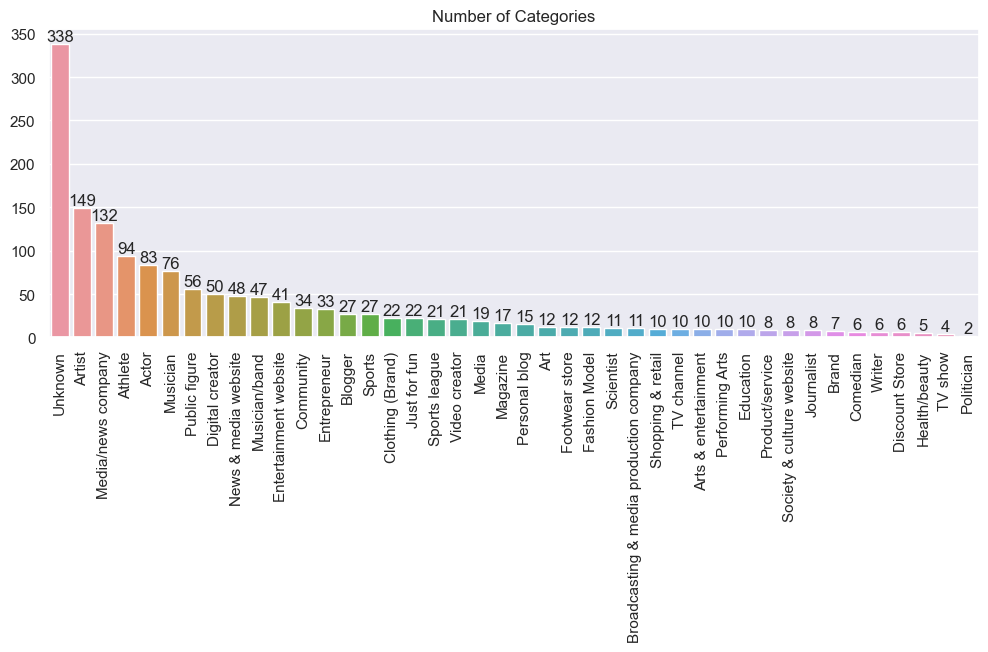

In [19]:
x = list(main_df['category_name'].value_counts().index)
y = list(main_df['category_name'].value_counts())
plt.figure(figsize=(12, 4))
ax = sns.barplot(data=main_df, x=x, y=y)
ax.bar_label(ax.containers[0])
plt.title('Number of Categories')
plt.xticks(rotation=90)
plt.show()

Except the images that their category is not detected by the Instagram, the top three categories present in the dataset are orderly, `Artist`, `Media/News Company` & `Athlete`.

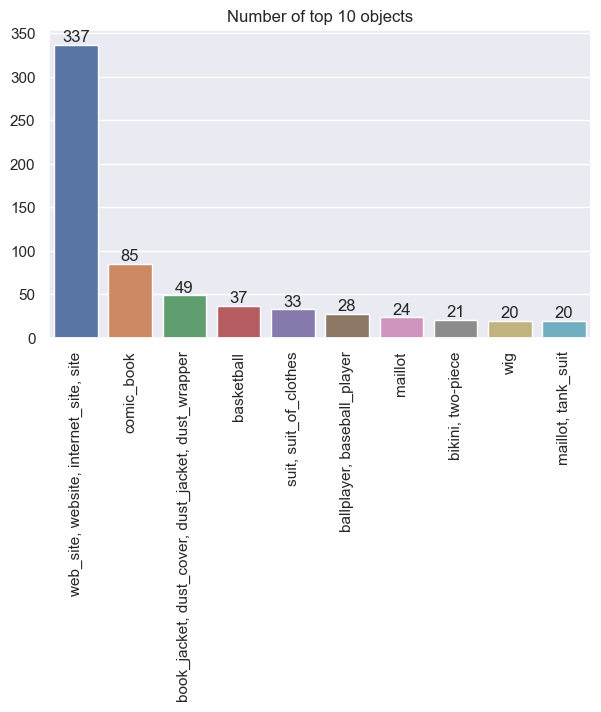

In [20]:
x = list(main_df['object'].value_counts()[:10].index)
y = list(main_df['object'].value_counts()[:10])
plt.figure(figsize=(7, 4))
ax = sns.barplot(data=main_df, x=x, y=y)
ax.bar_label(ax.containers[0])
plt.title('Number of top 10 objects')
plt.xticks(rotation=90)
plt.show()

In the graph above we can see the top 10 objects that was detected in the images. The most used object in the pictures are `website` related contents, in the second place are `comic` ones .

<BarContainer object of 2 artists>


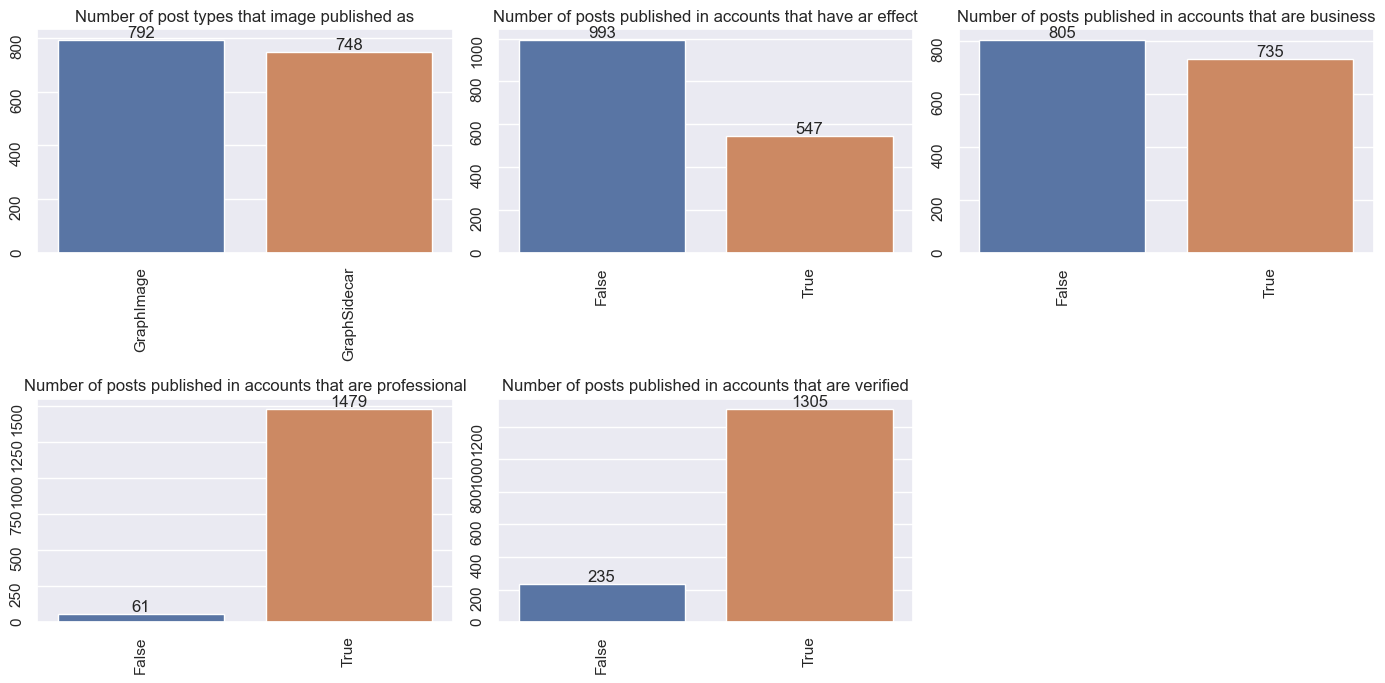

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
x = [
    list(main_df['post_type'].value_counts().index),
    list(main_df['ar_effect'].value_counts().index),
    list(main_df['type_business'].value_counts().index),
    list(main_df['type_professional'].value_counts().index),
    list(main_df['verified'].value_counts().index),
]
y = [
    list(main_df['post_type'].value_counts()),
    list(main_df['ar_effect'].value_counts()),
    list(main_df['type_business'].value_counts()),
    list(main_df['type_professional'].value_counts()),
    list(main_df['verified'].value_counts()),
]

sns.barplot(ax=axes[0, 0], x=x[0], y=y[0])
axes[0, 0].set_title('Number of post types that image published as')
axes[0, 0].bar_label(axes[0, 0].containers[0])
axes[0, 0].tick_params(labelrotation=90)
print(axes[0, 0].containers[0])

sns.barplot(ax=axes[0, 1], x=x[1], y=y[1])
axes[0, 1].set_title('Number of posts published in accounts that have ar effect')
axes[0, 1].bar_label(axes[0, 1].containers[0])
axes[0, 1].tick_params(labelrotation=90)

sns.barplot(ax=axes[0, 2], x=x[2], y=y[2])
axes[0, 2].set_title('Number of posts published in accounts that are business')
axes[0, 2].bar_label(axes[0, 2].containers[0])
axes[0, 2].tick_params(labelrotation=90)

sns.barplot(ax=axes[1, 0], x=x[3], y=y[3])
axes[1, 0].set_title('Number of posts published in accounts that are professional')
axes[1, 0].bar_label(axes[1, 0].containers[0])
axes[1, 0].tick_params(labelrotation=90)

sns.barplot(ax=axes[1, 1], x=x[4], y=y[4])
axes[1, 1].set_title('Number of posts published in accounts that are verified')
axes[1, 1].bar_label(axes[1, 1].containers[0])
axes[1, 1].tick_params(labelrotation=90)

fig.delaxes(axes[1, 2])

fig.tight_layout()
plt.show()

As you can see in the graph above, almost the share of posts between being images and carousels are even, 64.4% of the images are coming from accounts that **don't have published any ar effects** and 47.7% of the images are coming from accounts that are **business**. Majority of images are coming from accounts that are **professional** (96%) and **verified** (84.7%)

In [22]:
main_df.describe()

,id,like,comment,follower,following,reel_count,reel_avg_view,reel_avg_comment,reel_avg_like,reel_avg_duration,reel_frequency,media_count,media_avg_comment,media_avg_like,media_frequency
count,"1,540.00","1,540.00","1,540.00","1,540.00","1,540.00","1,540.00","1,540.00","1,540.00","1,540.00","1,540.00","1,540.00","1,540.00","1,540.00","1,540.00","1,540.00"
mean,"1,679,943,139.65","1,393,484.16","7,086.37","73,567,125.98",755.48,"5,710.03","3,285,012.65","5,392.69","714,289.75",259.41,18.91,"29,971.42","6,938.29","1,316,632.93",1.14
std,"4,764,367,868.19","2,764,194.05","20,392.79","106,599,432.60","1,232.15","8,959.45","5,244,730.10","11,848.42","1,575,787.76",572.49,25.87,"32,194.92","16,154.36","2,480,194.49",5.47
min,"787,132.00",0.00,0.00,"1,895.00",0.00,10.00,2.00,0.00,1.92,0.60,0.08,64.00,0.00,1.17,-29.57
25%,"145,821,237.00","2,188.00",32.00,"2,181,379.00",73.00,261.00,"77,709.83",79.00,"5,484.00",41.46,4.46,"2,064.00",75.58,"3,347.67",0.01
50%,"352,978,341.00","125,894.50",624.00,"56,086,097.00",264.00,"1,582.00","972,709.83",887.71,"122,777.00",61.46,12.10,"27,043.00",916.83,"135,452.67",0.12
75%,"1,547,627,005.00","1,396,191.75","4,626.00","78,606,444.00",916.25,"8,037.00","3,952,748.25","4,396.33","709,444.83",134.87,22.36,"47,630.00","4,800.25","1,419,182.08",2.36
max,"50,344,278,754.00","25,875,807.00","356,193.00","633,916,664.00","7,506.00","59,287.00","31,795,845.00","79,906.67","13,979,716.55","4,090.73",226.52,"139,315.00","115,771.50","14,580,544.00",36.08


The description of data which can be seen in the cell above, we won't dig deeper into the description since it will took a long time and won't be in the scope of the project.

In the next cell we will explore the correlation heatmap between the features.

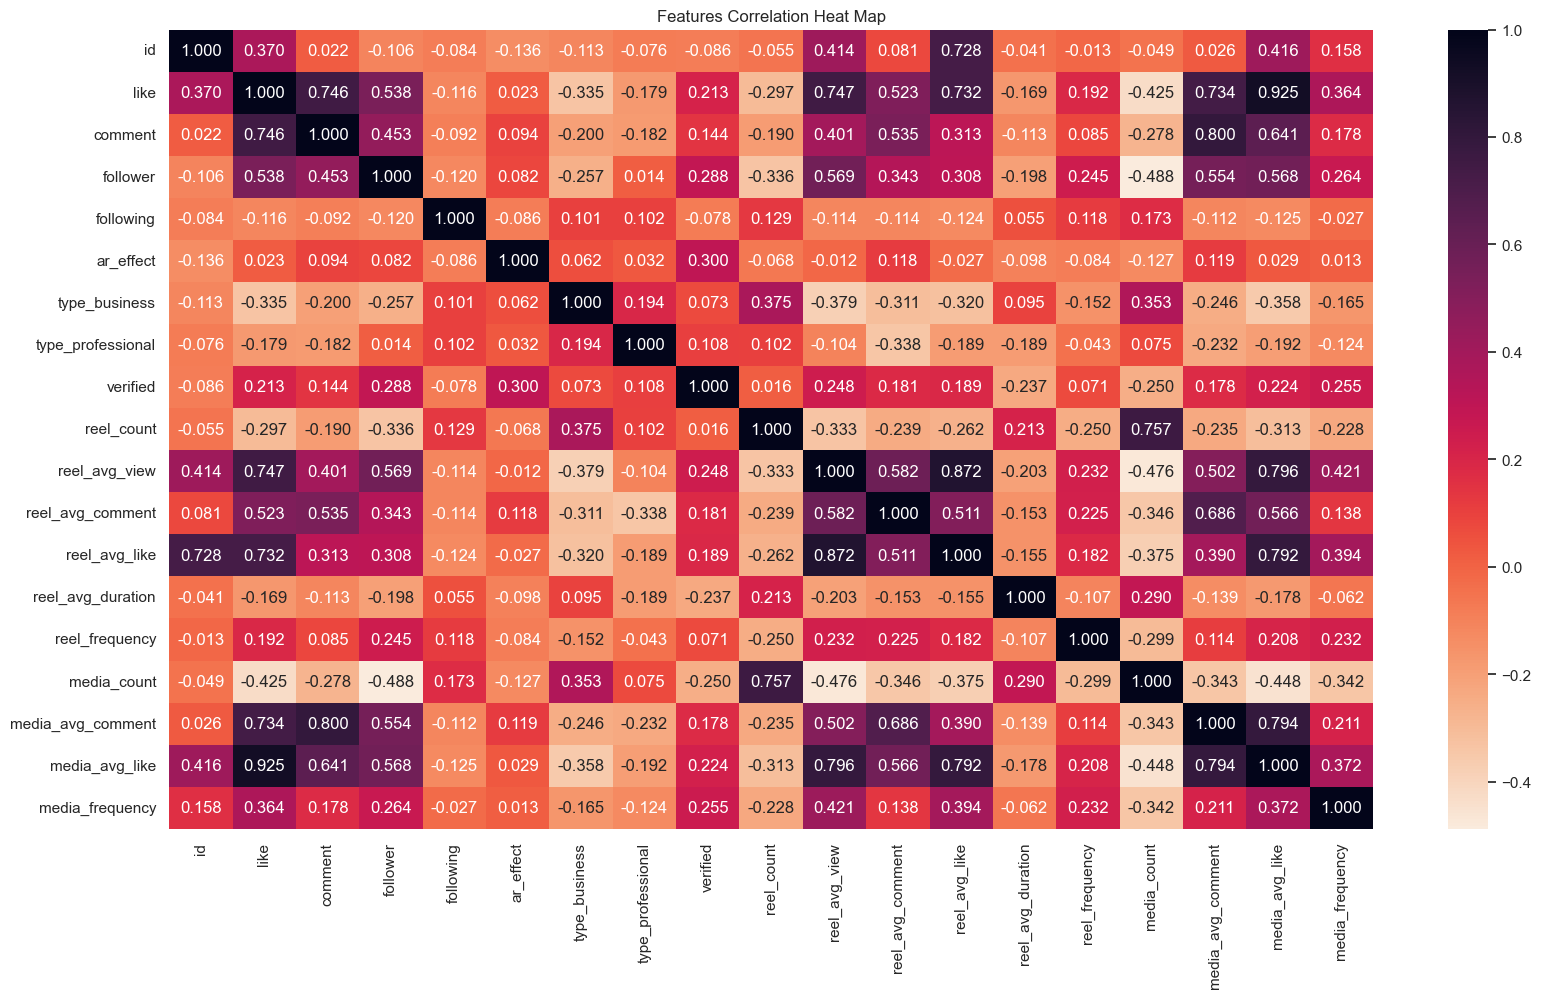

In [23]:
intercorr = main_df.corr()
plt.figure(figsize=(17, 10))
sns.heatmap(intercorr,annot=True, cmap='rocket_r', fmt='.3f')
plt.tight_layout()
plt.title('Features Correlation Heat Map')
plt.show()

Like the description, I won't delve deeply into this graph, but have in mind with this graph we can see a soft feature importance which will affect the XGBoost model. Using this insight we can eliminate some less important features in cases where we have limited resources such as computing power and/or time.

After all of these endeavors, we can train the model. To make the workspace more clear, we will train the model explore it, and visualize it in another notebook.

----
`@Ramin F.` | [Email](ferdos.ramin@gmail.com) | [LinkedIn](https://www.linkedin.com/in/raminferdos/) | [GitHub](https://github.com/SimplyRamin) | [Personal Portfolio](https://simplyramin.github.io/)